## create dataset 

v1:単純に縦方向に連結する  

In [21]:
import pandas as pd
import numpy as np

In [22]:
from pathlib import Path
root_dir = Path('../input')
# base_train = pd.read_csv(root_dir / 'baseline_locations_train.csv')
# base_test = pd.read_csv(root_dir / 'baseline_locations_test.csv')

# sub = pd.read_csv(root_dir / 'sample_submission.csv')

In [3]:

"""
# get GnssLog file 
for file in glob.glob(os.path.join(phone_path, "*.txt")):
    with open(file, encoding='utf-8') as f:
        txt = f.readlines()
# extract features from GnssLog
acc = []
gyro = []
mag = []
orient = []
status = [] 
raw = []
for i, line in enumerate(tqdm(txt)):
    line = line.strip().split(',')
    if line[0] == "UncalAccel":
        acc.append(line)
    elif line[0] == "UncalGyro":
        gyro.append(line)
    elif line[0] == 'UncalMag':
        mag.append(line)
    elif line[0] == 'OrientationDeg':
        orient.append(line)
    elif line[0] == 'Status':
        status.append(line)
    elif line[0] == 'Raw':
        raw.append(line)

acc_df = pd.DataFrame(acc)
gyro_df = pd.DataFrame(gyro)
mag_df = pd.DataFrame(mag)
status_df = pd.DataFrame(status)
raw_df = pd.DataFrame(raw)
"""

'\n# get GnssLog file \nfor file in glob.glob(os.path.join(phone_path, "*.txt")):\n    with open(file, encoding=\'utf-8\') as f:\n        txt = f.readlines()\n# extract features from GnssLog\nacc = []\ngyro = []\nmag = []\norient = []\nstatus = []\nraw = []\nfor i, line in enumerate(tqdm(txt)):\n    line = line.strip().split(\',\')\n    if line[0] == "UncalAccel":\n        acc.append(line)\n    elif line[0] == "UncalGyro":\n        gyro.append(line)\n    elif line[0] == \'UncalMag\':\n        mag.append(line)\n    elif line[0] == \'OrientationDeg\':\n        orient.append(line)\n    elif line[0] == \'Status\':\n        status.append(line)\n    elif line[0] == \'Raw\':\n        raw.append(line)\n\nacc_df = pd.DataFrame(acc)\ngyro_df = pd.DataFrame(gyro)\nmag_df = pd.DataFrame(mag)\nstatus_df = pd.DataFrame(status)\nraw_df = pd.DataFrame(raw)\n'

In [6]:
import glob
import os
from tqdm.notebook import tqdm


def create_dataset(collection_path):
    phase = collection_path.split('/')[2]
    output_df = pd.DataFrame()

    # get ground truth file
    for phone_path in glob.glob(os.path.join(collection_path, '*')):

        # get derived file (only 1 file)
        for derived_path in glob.glob(os.path.join(phone_path, "*_derived.csv")):
            derived_df = pd.read_csv(derived_path)
        if phase == 'test':
            return derived_df

        target_df = pd.read_csv(phone_path + '/ground_truth.csv')
        
        # merge derived and target by 'millisSinceGpsEpoch'
        for epoch, epoch_df in derived_df.groupby('millisSinceGpsEpoch'):
            idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
            epoch_diff = epoch - target_df.loc[idx, 'millisSinceGpsEpoch']
            epoch_df['epoch_diff'] = epoch_diff
            epoch_df['heightAboveWgs84EllipsoidM'] = target_df.loc[idx, 'heightAboveWgs84EllipsoidM']
            epoch_df['timeSinceFirstFixSeconds'] = target_df.loc[idx, 'timeSinceFirstFixSeconds']
            epoch_df['hDop'] = target_df.loc[idx, 'hDop']
            epoch_df['vDop'] = target_df.loc[idx, 'vDop']
            epoch_df['speedMps'] = target_df.loc[idx, 'speedMps']
            epoch_df['courseDegree'] = target_df.loc[idx, 'courseDegree']
            if phase == 'train':
                epoch_df['latDeg'] = target_df.loc[idx, 'latDeg']
                epoch_df['lngDeg'] = target_df.loc[idx, 'lngDeg']
            output_df = pd.concat([output_df, epoch_df]).reset_index(drop=True)    
    return output_df

## train

In [7]:
import multiprocessing

processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    path_list = glob.glob(os.path.join(root_dir, 'train/*'))
    dfs = pool.imap_unordered(create_dataset, path_list)
    dfs = tqdm(dfs, total=len(path_list))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch'])

  0%|          | 0/29 [00:00<?, ?it/s]

In [8]:
train_df

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,...,tropoDelayM,epoch_diff,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,latDeg,lngDeg
51816,2020-05-14-US-MTV-1,Pixel4,1273529464442,3,24,GLO_G1,1273529463363061857,-2.539901e+07,-6.925122e+05,-2.280430e+06,...,16.647,0,33.21,552.44,1.1,0.0,0.0,12.7,37.423576,-122.094132
51817,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,13,GAL_E1,1273529463363970742,-5.199894e+06,-1.741927e+07,2.336128e+07,...,2.717,0,33.21,552.44,1.1,0.0,0.0,12.7,37.423576,-122.094132
51818,2020-05-14-US-MTV-1,Pixel4,1273529464442,1,5,GPS_L1,1273529463365539137,-2.179863e+06,-2.615488e+07,-3.437694e+06,...,5.704,0,33.21,552.44,1.1,0.0,0.0,12.7,37.423576,-122.094132
51819,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,15,GAL_E1,1273529463352380595,1.635469e+07,-1.047833e+07,2.234460e+07,...,9.151,0,33.21,552.44,1.1,0.0,0.0,12.7,37.423576,-122.094132
51820,2020-05-14-US-MTV-1,Pixel4,1273529464442,6,21,GAL_E1,1273529463364075083,-1.484042e+07,-2.110960e+07,1.449632e+07,...,2.544,0,33.21,552.44,1.1,0.0,0.0,12.7,37.423576,-122.094132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60117,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760319000,1,28,GPS_L1,1303760318925801608,7.442565e+06,-2.100832e+07,1.515082e+07,...,4.031,0,56.64,2636.00,1.1,0.0,0.0,60.0,37.334475,-121.899613
60118,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760319000,6,36,GAL_E1,1303760318920879783,-8.060207e+06,-2.669204e+07,9.918403e+06,...,2.807,0,56.64,2636.00,1.1,0.0,0.0,60.0,37.334475,-121.899613
60119,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760319000,1,6,GPS_L5,1303760318928698727,-5.685876e+06,-2.562498e+07,3.907058e+06,...,3.404,0,56.64,2636.00,1.1,0.0,0.0,60.0,37.334475,-121.899613
60120,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760319000,1,30,GPS_L1,1303760318916948848,1.074593e+06,-2.406319e+07,-1.087155e+07,...,20.241,0,56.64,2636.00,1.1,0.0,0.0,60.0,37.334475,-121.899613


<AxesSubplot:>

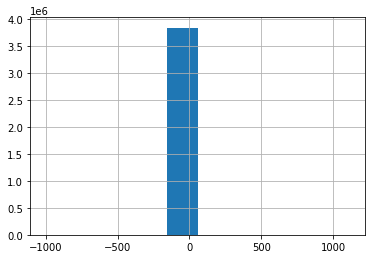

In [9]:
train_df['epoch_diff'].hist()

In [10]:
train_df['epoch_diff'].unique()

array([    0,    -1,   999,  1000,  1114, -1001,  1085])

In [16]:
train_df[train_df['epoch_diff'].abs() > 100]

,collectionName,phoneName,millisSinceGpsEpoch,constellationType,svid,signalType,receivedSvTimeInGpsNanos,xSatPosM,ySatPosM,zSatPosM,...,tropoDelayM,epoch_diff,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,latDeg,lngDeg
43,2020-05-14-US-MTV-2,Pixel4XLModded,1273538844448,1,5,GPS_L1,1273538843376067181,5.624286e+06,-1.603169e+07,2.023111e+07,...,3.800,999,33.64,146.45,0.5,0.0,0.0,158.6,37.690194,-122.392328
44,2020-05-14-US-MTV-2,Pixel4XLModded,1273538844448,1,21,GPS_L1,1273538843374568586,-2.319257e+07,-4.721628e+06,1.255680e+07,...,3.887,999,33.64,146.45,0.5,0.0,0.0,158.6,37.690194,-122.392328
45,2020-05-14-US-MTV-2,Pixel4XLModded,1273538844448,6,1,GAL_E1,1273538843365487903,-2.510194e+07,-1.453308e+07,5.902541e+06,...,3.510,999,33.64,146.45,0.5,0.0,0.0,158.6,37.690194,-122.392328
46,2020-05-14-US-MTV-2,Pixel4XLModded,1273538844448,1,25,GPS_L1,1273538843376073381,-1.664646e+07,-2.082784e+07,1.268037e+06,...,3.542,999,33.64,146.45,0.5,0.0,0.0,158.6,37.690194,-122.392328
47,2020-05-14-US-MTV-2,Pixel4XLModded,1273538844448,3,14,GLO_G1,1273538843378153477,-2.264347e+07,-3.936339e+06,1.105835e+07,...,4.191,999,33.64,146.45,0.5,0.0,0.0,158.6,37.690194,-122.392328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134000,2021-04-29-US-SJC-2,Pixel4,1303760277435,1,28,GPS_L1,1303760276360640733,7.381364e+06,-2.096020e+07,1.524991e+07,...,4.013,1000,56.59,2593.43,0.8,0.0,0.0,60.0,37.334473,-121.899612
134001,2021-04-29-US-SJC-2,Pixel4,1303760277435,6,36,GAL_E1,1303760276355641099,-8.075926e+06,-2.673166e+07,9.798117e+06,...,2.814,1000,56.59,2593.43,0.8,0.0,0.0,60.0,37.334473,-121.899612
134002,2021-04-29-US-SJC-2,Pixel4,1303760277435,1,6,GPS_L5,1303760276363439995,-5.700700e+06,-2.564161e+07,3.771669e+06,...,3.421,1000,56.59,2593.43,0.8,0.0,0.0,60.0,37.334473,-121.899612
134003,2021-04-29-US-SJC-2,Pixel4,1303760277435,1,30,GPS_L1,1303760276351845559,1.044236e+06,-2.411605e+07,-1.075639e+07,...,19.512,1000,56.59,2593.43,0.8,0.0,0.0,60.0,37.334473,-121.899612


## test

In [11]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    path_list = glob.glob(os.path.join(root_dir, 'test/*'))
    dfs = pool.imap_unordered(create_dataset, path_list)
    dfs = tqdm(dfs, total=len(path_list))
    dfs = list(dfs)
test_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName','millisSinceGpsEpoch'])

  0%|          | 0/19 [00:00<?, ?it/s]

In [24]:
output_dir = '../input/dataset_v1/'
os.makedirs(output_dir, exist_ok=True)

In [25]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)

In [20]:
to_pickle(output_dir + 'train.pkl', train_df)
to_pickle(output_dir + 'test.pkl', test_df)

## ちょっと検証

In [84]:
def from_pickle(filename):
    with open(filename, mode='rb') as f:
        obj = pickle.load(f)
    return obj

In [85]:
train_df = from_pickle(output_dir + 'train.pkl')

(array([4.9040e+03, 7.0277e+04, 5.0521e+04, 1.3100e+03, 4.5500e+02,
        1.1240e+03, 2.6800e+02, 1.0000e+01, 3.0000e+00, 3.4000e+01]),
 array([  4. ,  17.2,  30.4,  43.6,  56.8,  70. ,  83.2,  96.4, 109.6,
        122.8, 136. ]),
 <BarContainer object of 10 artists>)

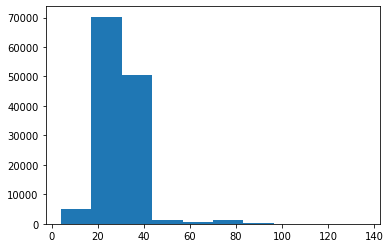

In [37]:
import matplotlib.pyplot as plt
x = train_df['millisSinceGpsEpoch'].value_counts().values
plt.hist(x)

In [42]:
train_df['millisSinceGpsEpoch'].unique()

128906

In [59]:
# 各collectionのODの測定時刻単位はmin
(train_df.groupby('collectionName')['millisSinceGpsEpoch'].max() - train_df.groupby('collectionName')['millisSinceGpsEpoch'].min()) / (1000*60)

collectionName
2020-05-14-US-MTV-1    29.116767
2020-05-14-US-MTV-2    29.466667
2020-05-21-US-MTV-1    33.883333
2020-05-21-US-MTV-2    32.766517
2020-05-29-US-MTV-1    32.066667
2020-05-29-US-MTV-2    32.350000
2020-06-04-US-MTV-1    29.499867
2020-06-05-US-MTV-1    35.683267
2020-06-05-US-MTV-2    30.100000
2020-06-11-US-MTV-1    33.350267
2020-07-08-US-MTV-1    37.249867
2020-07-17-US-MTV-1    34.883333
2020-07-17-US-MTV-2    29.000000
2020-08-03-US-MTV-1    33.466667
2020-08-06-US-MTV-2    29.816883
2020-09-04-US-SF-1     29.170183
2020-09-04-US-SF-2     41.676183
2021-01-04-US-RWC-1    34.571750
2021-01-04-US-RWC-2    32.200000
2021-01-05-US-SVL-1    23.933400
2021-01-05-US-SVL-2    20.983333
2021-03-10-US-SVL-1    25.566683
2021-04-15-US-MTV-1    29.142583
2021-04-22-US-SJC-1    48.166667
2021-04-26-US-SVL-1    17.240617
2021-04-28-US-MTV-1    33.292767
2021-04-28-US-SJC-1    34.683317
2021-04-29-US-MTV-1    27.655500
2021-04-29-US-SJC-2    39.526083
Name: millisSinceGpsEpoch, d

In [67]:
epoch = train_df.loc[train_df['collectionName']=='2020-05-14-US-MTV-1', 'millisSinceGpsEpoch'].to_numpy()
epoch_diff = epoch - np.min(epoch)

In [69]:
x = epoch_diff
y = np.ones(len(x))

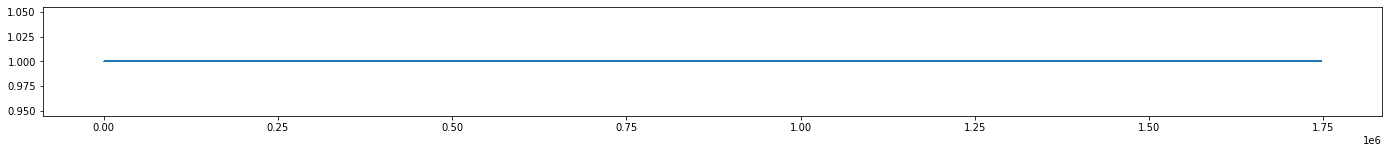

In [78]:
fig = plt.figure(figsize=(24,2))
ax = fig.add_subplot()
ax.scatter(x,y, s=1, marker='+')

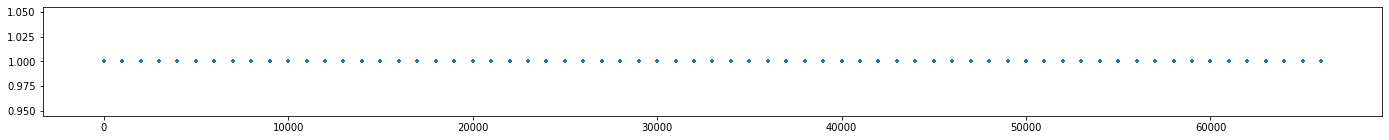

In [83]:
fig = plt.figure(figsize=(24,2))
ax = fig.add_subplot()
ax.scatter(x[:2000],y[:2000], s=10, marker='+')

1秒ずつと考えて良さそう  

In [87]:
# train_df[['xSatPosM','ySatPosM','zSatPosM']]

,xSatPosM,ySatPosM,zSatPosM
51816,-2.539901e+07,-6.925122e+05,-2.280430e+06
51817,-5.199894e+06,-1.741927e+07,2.336128e+07
51818,-2.179863e+06,-2.615488e+07,-3.437694e+06
51819,1.635469e+07,-1.047833e+07,2.234460e+07
51820,-1.484042e+07,-2.110960e+07,1.449632e+07
...,...,...,...
60117,7.442565e+06,-2.100832e+07,1.515082e+07
60118,-8.060207e+06,-2.669204e+07,9.918403e+06
60119,-5.685876e+06,-2.562498e+07,3.907058e+06
60120,1.074593e+06,-2.406319e+07,-1.087155e+07


In [88]:
train_df['xSatPosM'].nunique()

3665774